# Combining Datasets and Saving them to a Database File

***KJ MoChroi  
DSC 540 Fall 2022  
Bellevue University***

**Change Control Log:**  

Change#: 1  
Change(s) Made:  Imported data from three sources and cleaned it.  
Date of Change:  11/16/2022  
Author: Karlie Schwartzwald  
Change Approved by: Karlie Schwartzwald  
Date Moved to Production: 11/19/2022  

Change#: 2  
Change(s) Made:  Converted dataframes to tables in SQL database and merged those tables.  
Date of Change:  11/17/2022  
Author: Karlie Schwartzwald  
Change Approved by: Karlie Schwartzwald  
Date Moved to Production: 11/19/2022  

Change#: 3  
Change(s) Made:  produced visualizations.  
Date of Change:  11/17/2022  
Author: Karlie Schwartzwald  
Change Approved by: Karlie Schwartzwald  
Date Moved to Production: 11/19/2022  

Change#: 4  
Change(s) Made:  Completed Write-up.  
Date of Change:  11/17/2022  
Author: Karlie Schwartzwald  
Change Approved by: Karlie Schwartzwald  
Date Moved to Production: 11/19/2022  

## API Data

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
# See if we can connect to API
response = requests.get("https://world-happiness-database.herokuapp.com/api/happiness")
print(response.status_code)

200


In [3]:
# Extract Data from the Request using the Json() Method
json = response.json()

In [4]:
# Turn json into dataframe
api_df = pd.DataFrame(json)

In [5]:
# Drop columns
api_df = api_df[['country', 'happiness']]

In [6]:
# Rename columns
api_df.columns = ['Country', 'Happiness']

In [7]:
# sort alphabetically by Country
api_df.sort_values('Country', inplace=True)

In [8]:
# Alter names of countries so tables can join
api_df["Country"]= api_df["Country"].replace("Czech Republic","Czechia")

In [9]:
api_df["Country"]= api_df["Country"].replace("Palestinian Territories","Palestine")

## HTML Data

In [10]:
# Libraries
from bs4 import BeautifulSoup

In [11]:
# Create an URL object
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'

In [12]:
# Create object page
page = requests.get(url)

In [13]:
# parser-lxml = Change html to Python friendly format
# Obtain page's information
soup = BeautifulSoup(page.text, 'lxml')

In [14]:
table = soup.find("table", {"class": "wikitable"})

In [15]:
# Obtain column names with tag <th>
headers = []
for i in table.find_all('th'):
    title = i.text
    headers.append(title)

In [16]:
headers = ['Country',
 'UN Region',
 'IMF Estimate',
'IMF Year',
 'World Bank Estimate',
'World Bank Year',
 'United Nations Estimate',
'United Nations Year'
]
# The previous headers didn't make sense because of the way the cells are merged on the original table.

In [17]:
# Turn table into a dataframe for easier reading.
html_df = pd.DataFrame(columns = headers)

In [18]:
# Create a for loop to fill dataframe
for j in table.find_all('tr')[3:]:
    row_data= j.find_all('td')
    row = [i.text for i in row_data]
    holder = []
    for item in row:
        holder.append(item)
        if item == '—' or item == '—\n':
            holder.append('—')  # This is for rows with merged cells on webpage
    length = len(html_df)
    html_df.loc[length] = holder

In [19]:
html_df.drop(['IMF Year', 'World Bank Year', 'United Nations Year'], axis=1, inplace=True)

In [20]:
# Remove sepcial characters
html_df['IMF Estimate'] = html_df['IMF Estimate'].str.replace('\W', '', regex=True)
html_df['World Bank Estimate'] = html_df['World Bank Estimate'].str.replace('\W', '', regex=True)
html_df['United Nations Estimate'] = html_df['United Nations Estimate'].str.replace('\W', '', regex=True)

In [21]:
# convert estimates to numbers
html_df['IMF Estimate'] = pd.to_numeric(html_df['IMF Estimate'], errors='coerce')
html_df['World Bank Estimate'] = pd.to_numeric(html_df['World Bank Estimate'], errors='coerce')
html_df['United Nations Estimate'] = pd.to_numeric(html_df['United Nations Estimate'], errors='coerce')

In [22]:
# create new data column
html_df['Mean_GDP'] = html_df[['IMF Estimate', 'World Bank Estimate', 'United Nations Estimate']].mean(axis='columns')

In [23]:
# drop columns
html_df = html_df[['Country', 'Mean_GDP']]

In [24]:
# sort alphabetically by Country
html_df.sort_values('Country', inplace=True)

In [25]:
html_df["Country"]= html_df["Country"].replace("\xa0","") 
# Even after doing this step, these characters still show up in the SQL database after conversion

## Flat File Data

In [26]:
GDI_df = pd.read_csv('GDI.csv')

In [27]:
# Drop unnecesary columns
GDI_df = GDI_df[['Country', 'GDI_Value', 'Lif_Expec_Female', 'Lif_Excep_Male']]

In [28]:
# Convert columns to numerical and replace strings with NaN
GDI_df['GDI_Value'] = GDI_df['GDI_Value'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
GDI_df['GDI_Value'].isna().sum()

22

In [29]:
GDI_df['Lif_Expec_Female'] = GDI_df['Lif_Expec_Female'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
GDI_df['Lif_Expec_Female'].isna().sum()

6

In [30]:
GDI_df['Lif_Excep_Male'] = GDI_df['Lif_Excep_Male'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
GDI_df['Lif_Excep_Male'].isna().sum()

6

In [31]:
# Remove new NaN values from tables
GDI_df = GDI_df.dropna()

In [32]:
# sort alphabetically by Country
GDI_df.sort_values('Country', inplace=True)

In [33]:
# Alter names of countries so tables can join
GDI_df["Country"]= GDI_df["Country"].replace("Bolivia (Plurinational State of)", "Bolivia")

In [34]:
GDI_df["Country"]= GDI_df["Country"].replace("Iran (Islamic Republic of)","Iran")

In [35]:
GDI_df["Country"]= GDI_df["Country"].replace("Lao People's Democratic Republic","Laos")

In [36]:
GDI_df["Country"]= GDI_df["Country"].replace("Moldova (Republic of)","Moldova")

In [37]:
GDI_df["Country"]= GDI_df["Country"].replace("Palestine, State of","Palestine")

In [38]:
GDI_df["Country"]= GDI_df["Country"].replace("Russian Federation","Russia")

In [39]:
GDI_df["Country"]= GDI_df["Country"].replace("Korea (Republic of)","South Korea")

In [40]:
GDI_df["Country"]= GDI_df["Country"].replace("Syrian Arab Republic","Syria")

In [41]:
GDI_df["Country"]= GDI_df["Country"].replace("Tanzania (United Republic of)","Tanzania")

In [42]:
GDI_df["Country"]= GDI_df["Country"].replace("Venezuela (Bolivarian Republic of)","Venezuela")

In [43]:
GDI_df["Country"]= GDI_df["Country"].replace("Viet Nam","Vietnam")

## SQL Database

In [44]:
import sqlite3

In [45]:
#make connection to database
conn = sqlite3.connect('final_project.db')

In [46]:
# Convert dataframes into sql table
GDI_df.to_sql('gender', conn, if_exists='replace')

In [47]:
api_df.to_sql('happiness', conn, if_exists='replace')

In [48]:
html_df.to_sql('GDP', conn, if_exists='replace')

In [49]:
# Create cursor object
cursor = conn.cursor()

In [50]:
# selecting table for removing extra characters from strings:
sqlselect = '''
SELECT Country, Mean_GDP
FROM GDP
'''

In [51]:
# Executing the query
cursor.execute(sqlselect)

In [52]:
# removing extra characters from strings that appeared when converting from df to table:
sqlreplace = '''
UPDATE GDP
SET Country = REPLACE(Country, '\xa0', '')
'''

In [53]:
# Executing the query
cursor.execute(sqlreplace)

In [54]:
# to avoid error:
sql2 = '''DROP TABLE IF EXISTS joined_table;'''

In [55]:
# Executing the query
cursor.execute(sql2)

In [56]:
# Left Join both tables to gender table
sql3 = '''CREATE TABLE joined_table AS
SELECT gender.Country, gender.GDI_Value, gender.Lif_Expec_Female, gender.Lif_Excep_Male, happiness.Happiness, GDP.Mean_GDP
FROM gender
LEFT JOIN happiness ON gender.Country = happiness.Country
LEFT JOIN GDP ON gender.Country = GDP.Country;
'''

In [57]:
# Executing the query
cursor.execute(sql3)

In [58]:
# Dele rows with missing Happiness values
sqldelete = '''DELETE FROM joined_table
WHERE Happiness IS NULL;'''

In [59]:
# Executing the query
cursor.execute(sqldelete)

In [60]:
# Dele rows with missing GDP values
sqldelete2 = '''DELETE FROM joined_table
WHERE Mean_GDP IS NULL;'''

In [61]:
# Executing the query
cursor.execute(sqldelete2)

In [62]:
# select table
tableview = pd.read_sql_query("SELECT * FROM joined_table", conn)

In [63]:
# export to pandas dataframe for visualizations
df = pd.DataFrame(tableview, columns = ['Country', 'GDI_Value', 'Lif_Expec_Female', 'Lif_Excep_Male', 'Happiness', 'Mean_GDP'])

In [72]:
# Closing the connection
conn.close()

## Visualizations

In [65]:
# Human Readable Dataset
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)
print(df)

                      Country  GDI_Value  Lif_Expec_Female  Lif_Excep_Male  Happiness      Mean_GDP
0                 Afghanistan      0.659              66.4            63.4      2.694  2.001500e+04
1                     Albania      0.967              80.2            77.0      5.004  1.714200e+04
2                     Algeria      0.858              78.1            75.7      5.043  1.676090e+05
3                      Angola      0.903              64.0            58.4      3.795  8.654933e+04
4                   Argentina      0.993              80.0            73.2      5.793  5.017527e+05
5                     Armenia      0.982              78.5            71.3      5.062  1.473167e+04
6                   Australia      0.976              85.4            81.5      7.177  1.563640e+06
7                     Austria      0.964              83.9            79.2      7.396  4.594623e+05
8                  Azerbaijan      0.943              75.5            70.5      5.168  5.576500e+04


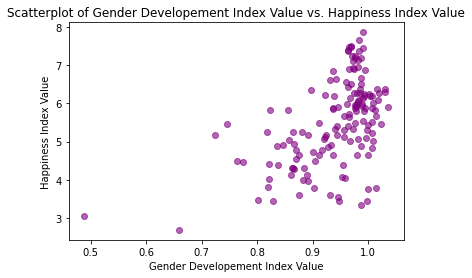

In [66]:
plt.scatter(df['GDI_Value'], df['Happiness'], alpha=0.6, color='purple')
plt.xlabel("Gender Developement Index Value")
plt.ylabel("Happiness Index Value")
plt.title('Scatterplot of Gender Developement Index Value vs. Happiness Index Value')
plt.show()

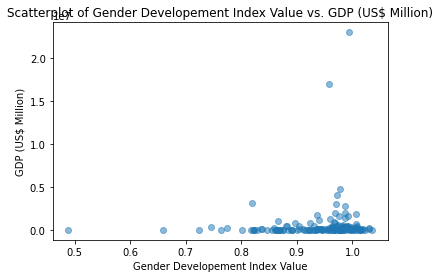

In [67]:
plt.scatter(df['GDI_Value'], df['Mean_GDP'], alpha=0.5)
plt.xlabel("Gender Developement Index Value")
plt.ylabel("GDP (US$ Million)")
plt.title('Scatterplot of Gender Developement Index Value vs. GDP (US$ Million)')
plt.show()

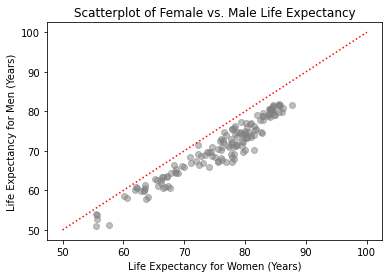

In [68]:
plt.scatter(df['Lif_Expec_Female'], df['Lif_Excep_Male'], alpha=0.5, color='gray')
plt.xlabel("Life Expectancy for Women (Years)")
plt.ylabel("Life Expectancy for Men (Years)")
x = np.linspace(50, 100, 1000)
plt.plot(x, x, color='red', linestyle=':')
plt.title('Scatterplot of Female vs. Male Life Expectancy')
plt.show()

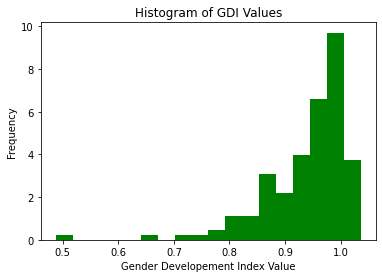

In [69]:
plt.hist(df['GDI_Value'], bins='auto', density=True, color='green')
plt.xlabel('Gender Developement Index Value')
plt.ylabel('Frequency')
plt.title('Histogram of GDI Values')
plt.show()

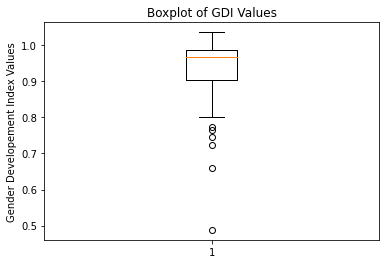

In [70]:
plt.boxplot(df['GDI_Value'])
plt.ylabel('Gender Developement Index Values')
plt.title('Boxplot of GDI Values')
plt.show()

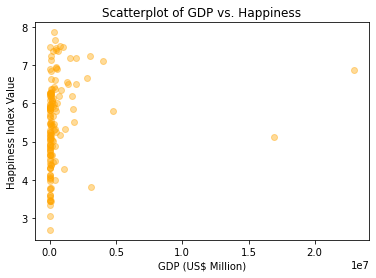

In [71]:
plt.scatter(df['Mean_GDP'], df['Happiness'], alpha=0.4, color='orange')
plt.xlabel("GDP (US$ Million)")
plt.ylabel("Happiness Index Value")
plt.title('Scatterplot of GDP vs. Happiness')
plt.show()

## Summary

In order to complete this project, I had to learn to do a handful of new things, and I was able to practice some skills that had been introduced to me in other courses. Starting with the things that are completely new to me, I pulled data from an API for the first time when learning to do this project. I also performed web scraping on a table from an html website for the first time. Once I had gotten my data, I was able to use my python skills to clean the data, like I had been taught to do in previous courses. However, once the dataframes were ready I had to learn how to convert them to tables inside an SQL database. I also ended up learning how to join tables inside databases, how to do string manipulation methods with SQL, and how to convert from a table in an SQL database back to a pandas dataframe. 

For ethical implications, the most blatant ethical issue comes from the fact that I am using population data divided along country lines. Every country constitutes a variety of peoples, and it may be unethical to draw arbitrary boundaries around these groups and then generalize about their gender equality or general happiness. Furthermore, I removed all time data related to the country metrics, and I assumed that gender equality data from 2019 will be relevant to the GDP of countries from 2019-2021. I also assumed that GDP will be generally stable year over year and that if 2021 data was missing for the GDP of a country, that it could be substituted with 2020 or 2019 data. The last ethical consideration I would make is that there are three different international organizations which are performing the GDP estimates. Each of these organizations has their own agendas and priorities about which territories are considered independent countries, and what their GDP should be, which could have influenced their estimates. 